In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

CSV_PATH = "merged_ev_forecasting_dataset_.csv"

In [3]:
df = pd.read_csv(CSV_PATH, parse_dates=["Date"]).sort_values("Date").set_index("Date")
print(df.shape)
print(df.head(3))
print(df.tail(3))

(105, 4)
            EV_Sales  Diesel_Price  Grant_Registrations  Chargers
Date                                                             
2016-01-01       584         132.7              54635.0    3672.0
2016-02-01       239         132.7              54635.0    3672.0
2016-03-01      2341         132.7              54635.0    3672.0
            EV_Sales  Diesel_Price  Grant_Registrations  Chargers
Date                                                             
2024-07-01     27335         153.9                  NaN   64632.0
2024-08-01     19113         153.9                  NaN       NaN
2024-09-01     56387         153.9                  NaN       NaN


In [4]:
# Ensure monthly start frequency (MS)
df = df.asfreq("MS")

# Enforce numeric dtypes (coerce bad strings to NaN)
for col in ["EV_Sales", "Diesel_Price", "Grant_Registrations", "Chargers"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Replace inf with NaN (just in case), we’ll handle next
df = df.replace([np.inf, -np.inf], np.nan)

assert df.index.is_monotonic_increasing
print(df.dtypes)

EV_Sales                 int64
Diesel_Price           float64
Grant_Registrations    float64
Chargers               float64
dtype: object


In [5]:
# ---- Step 4a: keep only needed cols, sort, set monthly freq ----
cols = ["EV_Sales", "Diesel_Price", "Grant_Registrations", "Chargers"]
df = df.sort_index()
df = df[cols].copy()
df = df.asfreq("MS")  # monthly start

print("Index start/end:", df.index.min(), "→", df.index.max())
print("Head:")
print(df.head(3))
print("Tail:")
print(df.tail(3))

Index start/end: 2016-01-01 00:00:00 → 2024-09-01 00:00:00
Head:
            EV_Sales  Diesel_Price  Grant_Registrations  Chargers
Date                                                             
2016-01-01       584         132.7              54635.0    3672.0
2016-02-01       239         132.7              54635.0    3672.0
2016-03-01      2341         132.7              54635.0    3672.0
Tail:
            EV_Sales  Diesel_Price  Grant_Registrations  Chargers
Date                                                             
2024-07-01     27335         153.9                  NaN   64632.0
2024-08-01     19113         153.9                  NaN       NaN
2024-09-01     56387         153.9                  NaN       NaN


In [6]:
# ---- Step 4b: check missingness before filling ----
print("Missing values BEFORE fill:")
print(df.isna().sum())

Missing values BEFORE fill:
EV_Sales                0
Diesel_Price            0
Grant_Registrations    47
Chargers                2
dtype: int64


In [7]:
# ---- Step 4c: minimal, defensible imputation for exogenous vars ----
# 1) Diesel price: time interpolation (monthly data; small gaps OK)
df["Diesel_Price"] = df["Diesel_Price"].interpolate(method="time")

# 2) Grants: if missing, assume zero registrations that month (conservative)
df["Grant_Registrations"] = df["Grant_Registrations"].fillna(0)

# 3) Chargers (quarterly → monthly): time interpolation; keep as float for modelling
df["Chargers"] = df["Chargers"].interpolate(method="time")

# 4) EV_Sales: if any missing edges, use time interpolation (rare, but safe)
df["EV_Sales"] = df["EV_Sales"].interpolate(method="time")

print("Missing values AFTER fill:")
print(df.isna().sum())

Missing values AFTER fill:
EV_Sales               0
Diesel_Price           0
Grant_Registrations    0
Chargers               0
dtype: int64


In [8]:
# ---- Step 4d: verify no infs/nans; drop any residual bad rows just in case ----
import numpy as np

bad = (~np.isfinite(df)).any(axis=1)
print("Rows with non-finite values:", int(bad.sum()))
if bad.any():
    df = df[~bad]

# Final y/X
y = df["EV_Sales"]
X = df[["Diesel_Price", "Grant_Registrations", "Chargers"]]

print("Final shapes:", y.shape, X.shape)
print("Sample check (last 5 rows):")
print(df.tail(5))

Rows with non-finite values: 0
Final shapes: (105,) (105, 3)
Sample check (last 5 rows):
            EV_Sales  Diesel_Price  Grant_Registrations  Chargers
Date                                                             
2024-05-01     26031         153.9                  0.0   59670.0
2024-06-01     34034         153.9                  0.0   59670.0
2024-07-01     27335         153.9                  0.0   64632.0
2024-08-01     19113         153.9                  0.0   64632.0
2024-09-01     56387         153.9                  0.0   64632.0


In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define endogenous (y) and exogenous (X) variables
y = df["EV_Sales"]
X = df[["Diesel_Price", "Grant_Registrations", "Chargers"]]

# Fit SARIMAX model
model = SARIMAX(
    y,
    exog=X,
    order=(1,1,1),              # (p,d,q) - can be tuned
    seasonal_order=(0,1,1,12),  # yearly seasonality (P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           EV_Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -766.116
Date:                            Tue, 19 Aug 2025   AIC                           1546.232
Time:                                    17:04:59   BIC                           1562.729
Sample:                                01-01-2016   HQIC                          1552.836
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Diesel_Price           -7.1662     44.481     -0.161      0.872     -94.347      80.015
Grant_Re

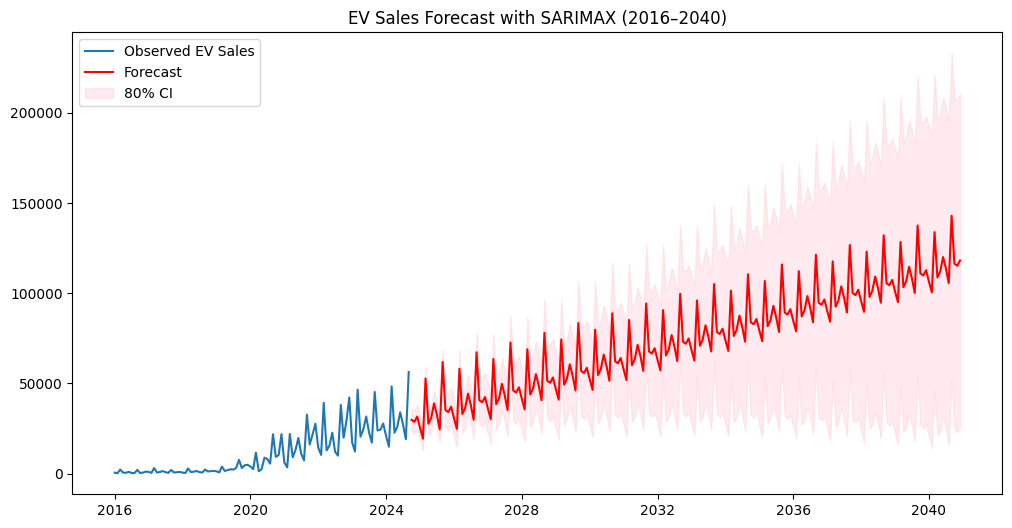

In [10]:
import matplotlib.pyplot as plt

# Forecast horizon: until 2040-12 (monthly steps)
forecast_steps = (2040 - 2024) * 12 + (12 - 9)  # from Sep 2024 → Dec 2040
future_index = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(1),
                             periods=forecast_steps, freq="MS")

# For exogenous regressors, extend with last known values (naïve assumption)
X_future = pd.DataFrame({
    "Diesel_Price": [df["Diesel_Price"].iloc[-1]] * forecast_steps,
    "Grant_Registrations": [df["Grant_Registrations"].iloc[-1]] * forecast_steps,
    "Chargers": [df["Chargers"].iloc[-1]] * forecast_steps
}, index=future_index)

# Forecast
forecast_res = results.get_forecast(steps=forecast_steps, exog=X_future)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int(alpha=0.2)  # 80% CI

# Plot
plt.figure(figsize=(12,6))
plt.plot(df.index, y, label="Observed EV Sales")
plt.plot(forecast_mean.index, forecast_mean, color="red", label="Forecast")
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color="pink", alpha=0.3, label="80% CI")
plt.legend()
plt.title("EV Sales Forecast with SARIMAX (2016–2040)")
plt.show()

In [11]:
# Select milestone years
milestones = ["2030-12-01", "2035-12-01", "2040-12-01"]

# Extract forecast mean + CI for those years
milestone_values = {}
for date in milestones:
    date = pd.to_datetime(date)
    if date in forecast_mean.index:
        milestone_values[date.strftime("%Y-%m")] = {
            "Forecast": int(forecast_mean.loc[date]),
            "Lower_80CI": int(forecast_ci.loc[date].iloc[0]),
            "Upper_80CI": int(forecast_ci.loc[date].iloc[1])
        }

# Convert to DataFrame for easy view
milestone_df = pd.DataFrame(milestone_values).T
print(milestone_df)

         Forecast  Lower_80CI  Upper_80CI
2030-12     64133       33648       94617
2035-12     91161       32784      149538
2040-12    118189       25461      210917
